<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net%20FN%20147.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm
from skimage.transform import resize


from keras.callbacks import TensorBoard

from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/lung_cancer/"
dataset = 'cleaned'
if dataset == 'small':
    img_path = PATH+'small_data/image_small/'
    mask_path = PATH+'small_data/mask_small/'
elif dataset == 'cleaned':
    img_path = PATH + 'cleaned_data/image_cleaned/'
    mask_path = PATH + 'cleaned_data/mask_cleaned/'
else:
    img_path = PATH+'big_data/images/image/'
    mask_path = PATH+'big_data/masks/mask/'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# #sample 100 patients from whole dataset
# import shutil
# path_from = "gdrive/My Drive/lung_cancer/big_data/"
# path_to = "gdrive/My Drive/lung_cancer/small_data/"
# # shutil.copy
# for i in range(1,743):
#     shutil.copy(path_from + 'images/image/'+img_ids[i], path_to +'image_small/'+ img_ids[i])
#     shutil.copy(path_from + 'masks/mask/' + label_ids[i], path_to +'mask_small/'+ label_ids[i])

In [2]:
img_ids = next(os.walk(img_path))[1]
mask_ids = next(os.walk(mask_path))[1]
img_ids.sort()
mask_ids.sort()
print(img_ids)
print(mask_ids)

print("number of images : ",len(img_ids))
print("number of masks : ",len(mask_ids))

assert len(img_ids) == len(mask_ids), "images and mask have different samples"

#TODO, size
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003', 'LIDC-IDRI-0004', 'LIDC-IDRI-0005', 'LIDC-IDRI-0006', 'LIDC-IDRI-0007', 'LIDC-IDRI-0008', 'LIDC-IDRI-0009', 'LIDC-IDRI-0010', 'LIDC-IDRI-0011', 'LIDC-IDRI-0012', 'LIDC-IDRI-0013', 'LIDC-IDRI-0014', 'LIDC-IDRI-0015', 'LIDC-IDRI-0016', 'LIDC-IDRI-0017', 'LIDC-IDRI-0018', 'LIDC-IDRI-0019', 'LIDC-IDRI-0020', 'LIDC-IDRI-0021', 'LIDC-IDRI-0022', 'LIDC-IDRI-0023', 'LIDC-IDRI-0024', 'LIDC-IDRI-0025', 'LIDC-IDRI-0026', 'LIDC-IDRI-0027', 'LIDC-IDRI-0029', 'LIDC-IDRI-0030', 'LIDC-IDRI-0031', 'LIDC-IDRI-0033', 'LIDC-IDRI-0034', 'LIDC-IDRI-0035', 'LIDC-IDRI-0036', 'LIDC-IDRI-0037', 'LIDC-IDRI-0038', 'LIDC-IDRI-0039', 'LIDC-IDRI-0040', 'LIDC-IDRI-0041', 'LIDC-IDRI-0042', 'LIDC-IDRI-0043', 'LIDC-IDRI-0044', 'LIDC-IDRI-0045', 'LIDC-IDRI-0046', 'LIDC-IDRI-0047', 'LIDC-IDRI-0048', 'LIDC-IDRI-0049', 'LIDC-IDRI-0050', 'LIDC-IDRI-0051', 'LIDC-IDRI-0052', 'LIDC-IDRI-0053', 'LIDC-IDRI-0054', 'LIDC-IDRI-0055', 'LIDC-IDRI-0056', 'LIDC-IDRI-0057', 'LIDC-IDR

In [3]:
#cleaned


# load all data to memory

# X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
train_test_split_ratio = 0.2 # test ratio
train_idx = np.random.choice(img_ids, int(len(img_ids) * (1-train_test_split_ratio)), replace=False)
# train_idx = img_ids[:int(len(img_ids)*0.8)]
test_idx = list(set(img_ids) - set(train_idx))

sys.stdout.flush()
# for n, train in tqdm(enumerate(train_idx), total=len(train_idx)):
#     train_imgs = next(os.walk(img_path + train))[2]
#     for _img in train_imgs:
#         path = img_path + train + "/" + _img
#         img = np.expand_dims(imread(path), axis=2)
#         # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#         X.append(img)

# X_train = np.array(X, dtype=np.uint8)

def read_dataset(path, idx, type):
    if type == 'image':
        X_set = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    else:
        X_set = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
    for n, i in tqdm(enumerate(idx), total=len(idx)):
        imgs = next(os.walk(path + i))[2]
        imgs.sort()
        if type == 'image':
            X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        else:
            X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
        for idx, _img in enumerate(imgs):
            p = path + i + "/" + _img
            img = np.expand_dims(imread(p), axis=2)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
            X_[idx] = img
        X_set = np.concatenate([X_set, X_], axis=0)

    return X_set

X_train_new = read_dataset(img_path, train_idx, 'image')
X_test_new = read_dataset(img_path, test_idx, 'image')

#normalize
X_train_new = (X_train_new - X_train_new.min()) / (X_train_new.max() - X_train_new.min())
X_test_new = (X_test_new - X_test_new.min()) / (X_test_new.max() - X_test_new.min())


Y_train_new = read_dataset(mask_path, train_idx, 'mask')
Y_test_new = read_dataset(mask_path, test_idx, 'mask')

    # for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    #     path = img_path +id_
    #     img = np.expand_dims(imread(path),axis=2)
    #     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #     X_train[n] = img

    # for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    #     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    #     path = mask_path+id_
    #     label = np.expand_dims(imread(path), axis=2)
    #     mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #     Y_train[n] = mask

# for test in test_idx:
#     for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
#         path = img_path +id_
#         img = np.expand_dims(imread(path),axis=2)
#         img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         X_train[n] = img

#     for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#         mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
#         path = mask_path+id_
#         label = np.expand_dims(imread(path), axis=2)
#         mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         Y_train[n] = mask


100%|██████████| 19/19 [02:59<00:00,  9.43s/it]


In [0]:
# plt.imshow(X_train[1][:,:,0])
# plt.show()
for i in range(0,10):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X_train_new[i][:,:,0])
    ax[1].imshow(Y_train_new[i][:,:,0])
    plt.show()

In [0]:
#original

# load all data to memory

# train_test_split_ratio = 0.2 # test ratio
# train_idx = np.random.choice(img_ids, int(len(img_ids) * (1-train_test_split_ratio)), replace=False)
# test_idx = list(set(img_ids) - set(train_idx))

sys.stdout.flush()
# for n, train in tqdm(enumerate(train_idx), total=len(train_idx)):
#     train_imgs = next(os.walk(img_path + train))[2]
#     for _img in train_imgs:
#         path = img_path + train + "/" + _img
#         img = np.expand_dims(imread(path), axis=2)
#         # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#         X.append(img)

# X_train = np.array(X, dtype=np.uint8)

# def read_dataset(path, idx):
#     X_set = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#     for n, i in tqdm(enumerate(idx), total=len(idx)):
#         imgs = next(os.walk(path + i))[2]
#         X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#         for idx, _img in enumerate(imgs):
#             p = path + i + "/" + _img
#             img = np.expand_dims(imread(p), axis=2)
#             img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#             X_[idx] = img
#         X_set = np.concatenate([X_set, X_], axis=0)

#     return X_set

# X_train = read_dataset(img_path, train_idx)
# X_test = read_dataset(img_path, test_idx)

# #normalize
# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())


# Y_train = read_dataset(mask_path, train_idx)
# Y_test = read_dataset(mask_path, test_idx)
# print(X_train.max(), X_test.max(), Y_train.max(), Y_test.max())



X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path +id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = mask_path+id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

# for test in test_idx:
#     for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
#         path = img_path +id_
#         img = np.expand_dims(imread(path),axis=2)
#         img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         X_train[n] = img

#     for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#         mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
#         path = mask_path+id_
#         label = np.expand_dims(imread(path), axis=2)
#         mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         Y_train[n] = mask


In [75]:
import tensorflow_addons as tfa
from keras import backend as K
# Define IoU metric
def IoU(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5),tf.float32)
    intersection = tf.reduce_sum(y_true*y_pred)
    union =tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union 

# earlystopper = EarlyStopping(patience=10, verbose=0)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)

def dice_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

gamma=2.
alpha=.25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))


def build_model(act):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x) (inputs)

    activ = act
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    opt = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss=focal_loss_fixed,metrics=[IoU])

    return model

def model_train(model,_X_train, _Y_train ):
    with tf.device('/device:GPU:0'):
        results = model.fit(_X_train, _Y_train, validation_split=0.1, batch_size=4, epochs=100, 
                        callbacks=[earlystopper, checkpointer], verbose=0)
    return results, model

def draw_fig(results, shuffle, norm, act, opt, loss, avail):
    title = "shuffle : {}, normalization : {}, activation : {}, optimizer : {}, loss function : {}, available prediction : {:.0%}".format(
        shuffle, norm, act, opt, loss, avail)
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    ax[0].plot(loss, 'r', label='loss')
    ax[0].plot(val_loss,'b',label='val_loss')
    ax[0].legend()
    _IoU = results.history['IoU']
    _val_IoU = results.history['val_IoU']
    ax[1].plot(_IoU, 'g',label='IoU')
    ax[1].plot(_val_IoU, 'c',label='val_IoU')
    ax[1].legend()
    plt.suptitle(title)
    plt.show()

# Predict on train, val and test
def count_valid_pred(model,_X_val, _Y_val):
    model = load_model('model-dsbowl2020-4.h5',{'IoU':IoU})
    preds_val = model.predict(_X_val, verbose=0)

    preds_val_t = (preds_val > 0.5).astype(np.uint8)

    IoU_vec = np.array([])
    '''
    print out images
    '''
    for i in range(10):
        ix = random.randint(0, len(_X_val))
        fig, ax = plt.subplots(1,3,figsize=(10,6))
        ax[0].imshow(_X_val[ix][:,:,0],cmap='gray')
        ax[0].axis('off')
        ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')

        c = measure.regionprops(preds_val_t[ix][:,0,0])
        print("len : ",len(c))
        ax[1].title.set_text("prediction")
        ax[1].axis('off')
        ax[2].imshow(np.squeeze(_Y_val[ix][:,:,0]),cmap='gray')
        ax[2].title.set_text("ground truth")
        ax[2].axis('off')
        plt.show()
        print("IoU : ",IoU(tf.convert_to_tensor(preds_val_t[ix],tf.float32),tf.convert_to_tensor(_Y_val[ix],tf.float32)).numpy())

    for i in range(len(preds_val_t)):
        IoU_vec = np.append(IoU_vec, IoU(tf.convert_to_tensor(preds_val_t[i],tf.float32),tf.convert_to_tensor(_Y_val[i],tf.float32)).numpy())
    return np.where(IoU_vec>0,1,0).mean()
model = build_model('relu')
model.load_weights('saved_w')

with tf.device('/device:GPU:0'):
    results = model.fit(X_train_new, Y_train_new, validation_split=0.1, batch_size=4, epochs=100, callbacks=[checkpointer], verbose=2)


def iter(shuffle, norm,  opt,act, loss):
    _X_train, _Y_train, _X_val, _Y_val = train_test_split(shuffle, norm, split_ratio = 0.8)
    model = build_model(act)
    results, model = model_train(model,_X_train, _Y_train)
    draw_fig(results, shuffle, norm, act, opt, loss, count_valid_pred(model,_X_val, _Y_val))
    return results

Train on 936 samples, validate on 104 samples
Epoch 1/100
 - 28s - loss: 1.0693e-04 - IoU: 0.4872 - val_loss: 3.0947e-04 - val_IoU: 0.0795

Epoch 00001: val_loss improved from inf to 0.00031, saving model to model-dsbowl2020-4.h5
Epoch 2/100
 - 27s - loss: 9.9852e-05 - IoU: 0.4820 - val_loss: 3.7273e-04 - val_IoU: 0.0624

Epoch 00002: val_loss did not improve from 0.00031
Epoch 3/100
 - 27s - loss: 1.0753e-04 - IoU: 0.4676 - val_loss: 3.1195e-04 - val_IoU: 0.0240

Epoch 00003: val_loss did not improve from 0.00031
Epoch 4/100
 - 27s - loss: 9.4755e-05 - IoU: 0.4813 - val_loss: 3.5727e-04 - val_IoU: 0.1120

Epoch 00004: val_loss did not improve from 0.00031
Epoch 5/100
 - 27s - loss: 8.9296e-05 - IoU: 0.5144 - val_loss: 3.4279e-04 - val_IoU: 0.0658

Epoch 00005: val_loss did not improve from 0.00031
Epoch 6/100
 - 27s - loss: 9.0693e-05 - IoU: 0.4803 - val_loss: 2.3815e-04 - val_IoU: 0.0949

Epoch 00006: val_loss improved from 0.00031 to 0.00024, saving model to model-dsbowl2020-4.h5
Ep

288


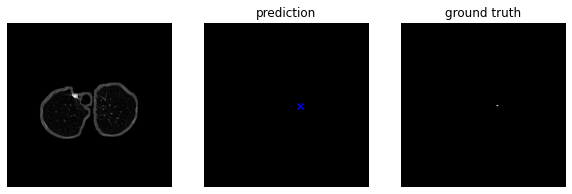

[]
[(259.05882352941177, 298.6470588235294)]
TP: 0, FP: 0, FN: 1
58


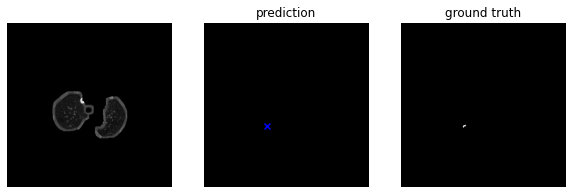

[]
[(322.3181818181818, 195.9318181818182)]
TP: 0, FP: 0, FN: 1
245


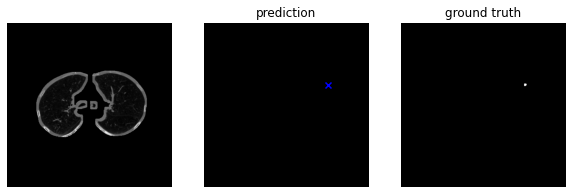

[]
[(194.16666666666666, 385.1111111111111)]
TP: 0, FP: 0, FN: 1
184


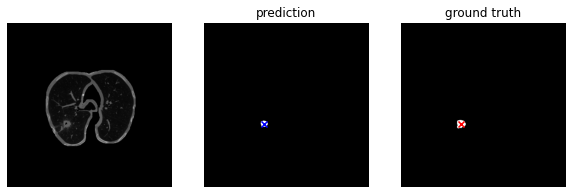

[(315.2920353982301, 186.07669616519175)]
[(316.08976660682225, 185.5870736086176)]
d^2 : 0.8761053290681029
TP: 1, FP: 0, FN: 0
310


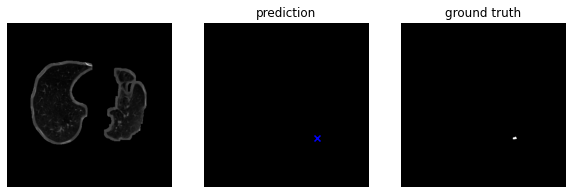

[]
[(360.0135135135135, 352.4864864864865)]
TP: 0, FP: 0, FN: 1
29


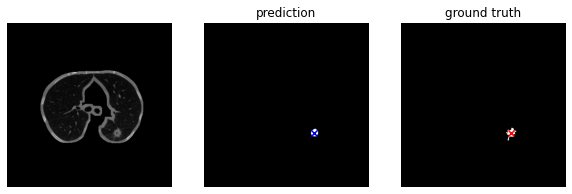

[(343.18045112781954, 342.64411027568923)]
[(344.1791907514451, 341.0712909441233)]
d^2 : 3.471241485547265
TP: 0, FP: 1, FN: 1
220


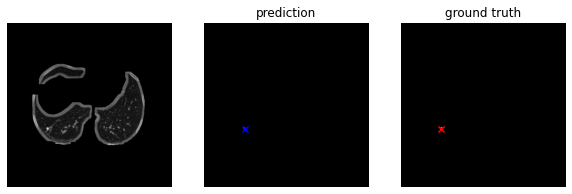

[(330.45454545454544, 125.57575757575758)]
[(330.75, 125.78846153846153)]
d^2 : 0.13253636417972675
TP: 1, FP: 0, FN: 0
23


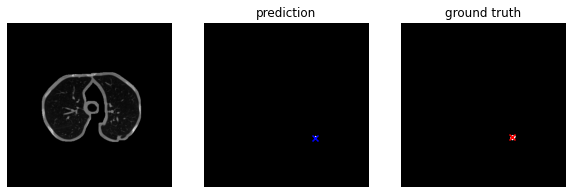

[(356.95348837209303, 346.1162790697674)]
[(358.020942408377, 346.8219895287958)]
d^2 : 1.637485371560981
TP: 1, FP: 0, FN: 0
245


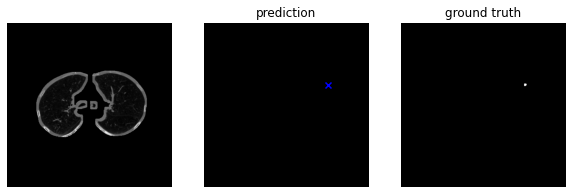

[]
[(194.16666666666666, 385.1111111111111)]
TP: 0, FP: 0, FN: 1
3


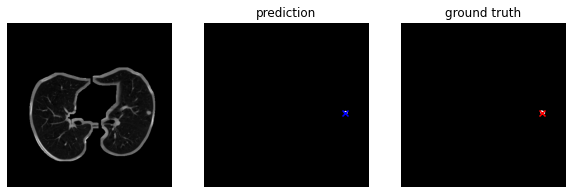

[(280.7029702970297, 439.36633663366337)]
[(280.41875, 438.79375)]
d^2 : 0.40863663029362035
TP: 1, FP: 0, FN: 0


In [77]:
from skimage import measure


X = X_test_new
Y = Y_test_new
model = load_model('model-dsbowl2020-4.h5',{'focal_loss_fixed':focal_loss_fixed, 'IoU':IoU})
preds_val = model.predict(X, verbose=0)

preds_val_t = (preds_val > 0.5).astype(np.uint8)

IoU_vec = np.array([])
'''
print out images
'''


def get_centers(image):
    r = []
    for pred_nodule in measure.regionprops(measure.label(image)):
        r.append(pred_nodule.centroid)
    return r


for i in range(10):
    TP=0
    FP=0
    FN=0
    pred = []
    tr = []
    ix = random.randint(0, len(X))
    print(ix)
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')



    for center in get_centers(np.squeeze(preds_val_t[ix][:,:,0])):
        ax[2].scatter(center[1], center[0], marker='x', color='r')
        pred.append(center)
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y[ix][:,:,0]),cmap='gray')
    for center in get_centers(np.squeeze(Y[ix][:,:,0])):
        ax[1].scatter(center[1], center[0], marker='x', color='b')
        tr.append(center)
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print(pred)
    print(tr)
    
    for p in pred:
        for t in tr:
            dist_sq = pow((p[0] - t[0]),2) + pow((p[1] - t[1]),2)
            print("d^2 : {}".format(dist_sq))
            if dist_sq < 2:
                TP+=1
                tr.remove(t)
    FP = len(pred) - TP
    for t in tr:
        FN+=1
    print(f"TP: {TP}, FP: {FP}, FN: {FN}")



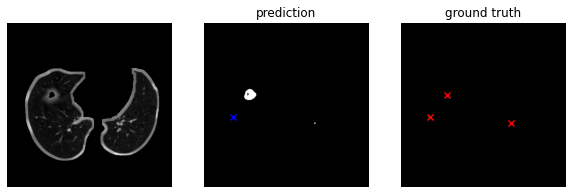

d^2 : 7599.786248097952  |d^2 : 1.439307851239657  |TP: 1, FP: 2, FN: 0


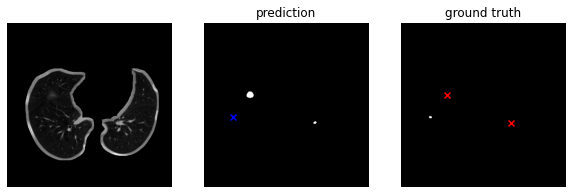

d^2 : 7487.098519388179  |d^2 : 64234.32576845733  |TP: 0, FP: 2, FN: 1


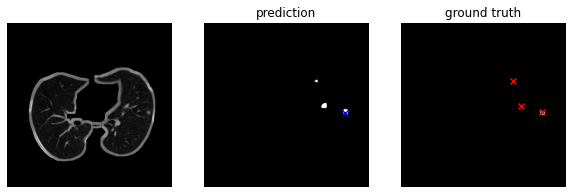

d^2 : 17852.295714970773  |d^2 : 4807.050761071454  |d^2 : 7.142207992751807  |TP: 1, FP: 2, FN: 0


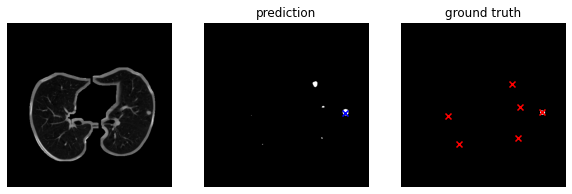

d^2 : 16717.321228791414  |d^2 : 5142.760174575617  |d^2 : 1.0373720177331496  |TP: 1, FP: 5, FN: 0


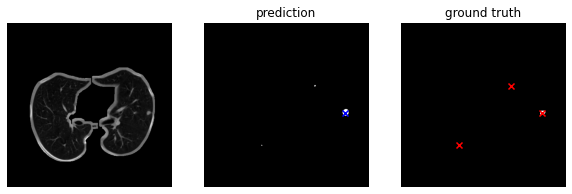

d^2 : 16043.347757621563  |d^2 : 1.019794419145142  |TP: 1, FP: 2, FN: 0


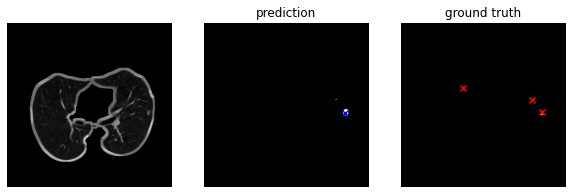

d^2 : 66021.222238351  |d^2 : 2687.6874115437645  |d^2 : 11.42941685926585  |TP: 1, FP: 2, FN: 0


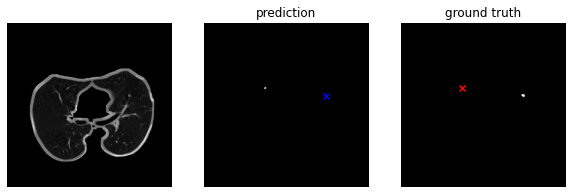

d^2 : 36348.03311422071  |TP: 0, FP: 1, FN: 1


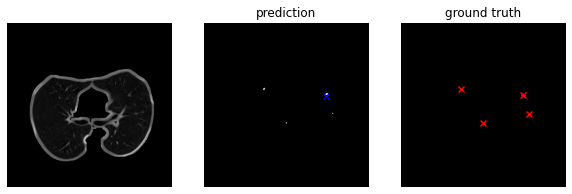

d^2 : 37950.89948945219  |d^2 : 4.093265177853111  |TP: 1, FP: 3, FN: 0


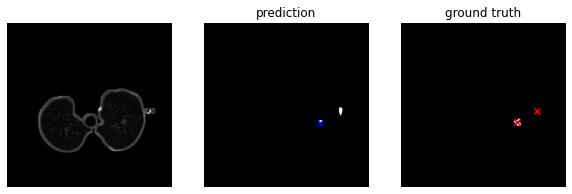

d^2 : 5015.659626609064  |d^2 : 8.04050657673183  |TP: 1, FP: 1, FN: 0


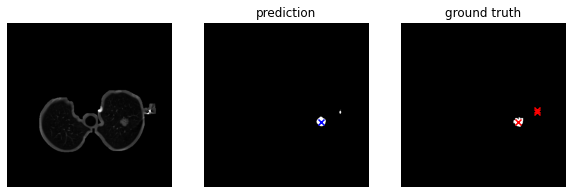

d^2 : 5034.170678828737  |d^2 : 4262.599352237419  |d^2 : 2.1216115412673124  |TP: 1, FP: 2, FN: 0


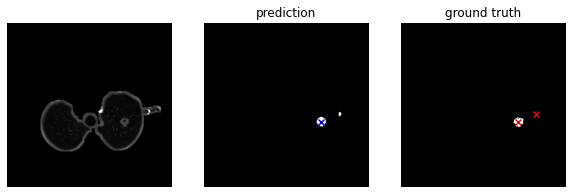

d^2 : 3783.421360773642  |d^2 : 1.9022465966989508  |TP: 1, FP: 1, FN: 0


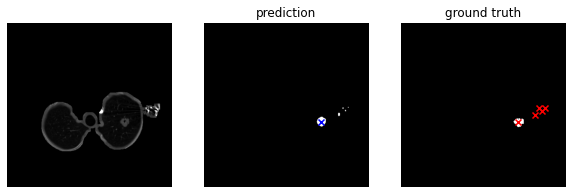

d^2 : 8803.7011200615  |d^2 : 6179.863342739511  |d^2 : 6633.63988702557  |d^2 : 3387.203393086436  |d^2 : 7.83467749419367  |TP: 1, FP: 4, FN: 0


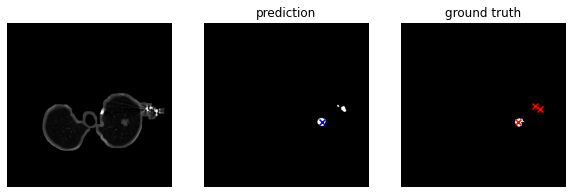

d^2 : 5054.017985198803  |d^2 : 6172.19939590533  |d^2 : 4.067988208862607  |TP: 1, FP: 2, FN: 0


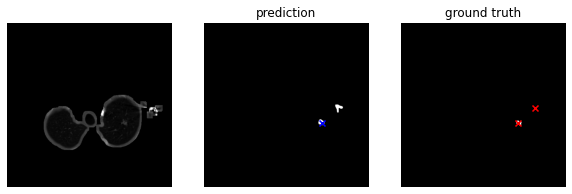

d^2 : 4907.726224202841  |d^2 : 8.710980661646271  |TP: 1, FP: 1, FN: 0


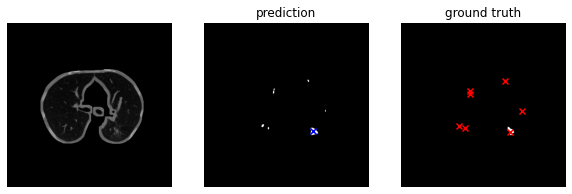

d^2 : 24570.036886651968  |d^2 : 30649.39909558535  |d^2 : 28554.98365479867  |d^2 : 5252.539099940732  |d^2 : 25349.465307480692  |d^2 : 19851.48905937882  |d^2 : 3.3059138922764286  |TP: 1, FP: 6, FN: 0


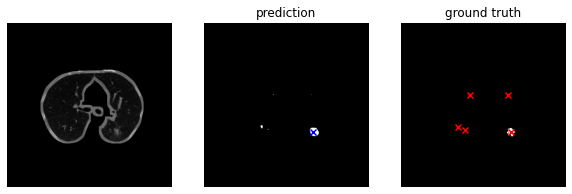

d^2 : 29226.60833637693  |d^2 : 13538.03232286341  |d^2 : 26548.58387008537  |d^2 : 1.0085179879801358  |TP: 1, FP: 4, FN: 0


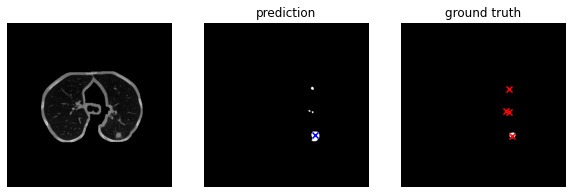

d^2 : 21216.576704625237  |d^2 : 6003.600375113403  |d^2 : 5167.20445702908  |d^2 : 9.101233330680248  |TP: 1, FP: 3, FN: 0


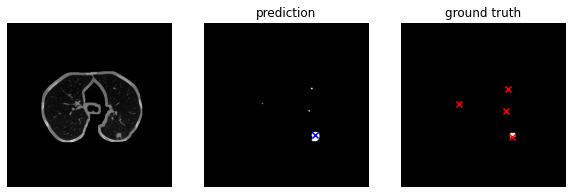

d^2 : 21138.415337268434  |d^2 : 36839.61936845952  |d^2 : 6097.944790172329  |d^2 : 17.354115094186895  |TP: 1, FP: 3, FN: 0


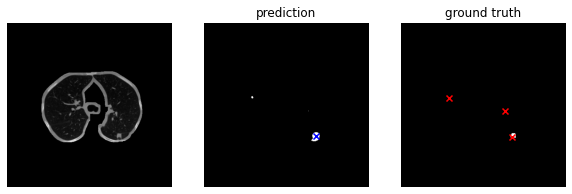

d^2 : 53557.13050071942  |d^2 : 6395.44395980002  |d^2 : 18.115896468723268  |TP: 1, FP: 2, FN: 0


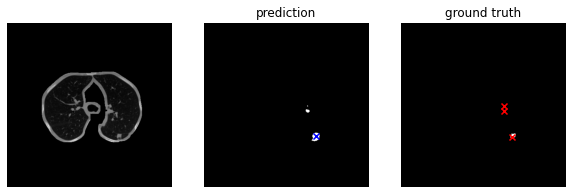

d^2 : 9172.537478373704  |d^2 : 6582.33224760134  |d^2 : 15.259717151218082  |TP: 1, FP: 2, FN: 0


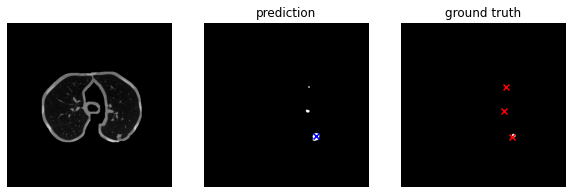

d^2 : 23634.50928604225  |d^2 : 6716.150135419417  |d^2 : 8.05338204389902  |TP: 1, FP: 2, FN: 0


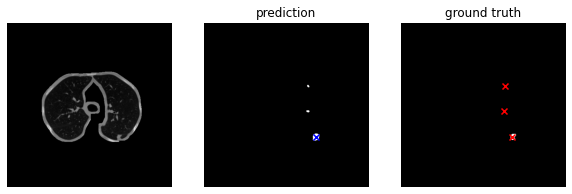

d^2 : 25257.492438446025  |d^2 : 6883.9272142863165  |d^2 : 1.2250947441338211  |TP: 1, FP: 2, FN: 0


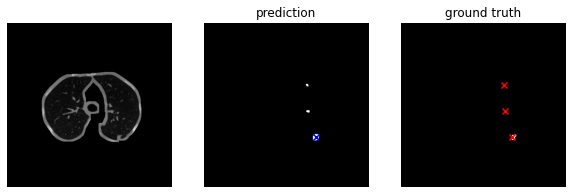

d^2 : 26938.81905866072  |d^2 : 7142.821959022204  |d^2 : 3.705807526722795  |TP: 1, FP: 2, FN: 0


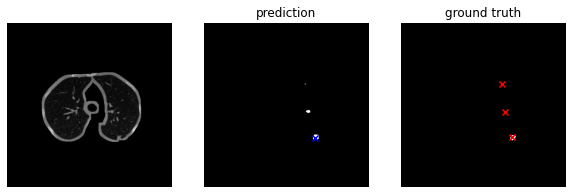

d^2 : 28754.024112635656  |d^2 : 7135.533327964778  |d^2 : 0.7924227063500389  |TP: 1, FP: 2, FN: 0


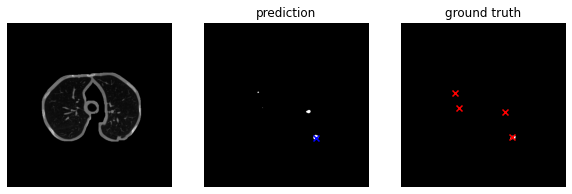

d^2 : 51912.02499009734  |d^2 : 36016.970801267555  |d^2 : 7028.072785391522  |d^2 : 0.9620848261623454  |TP: 1, FP: 3, FN: 0


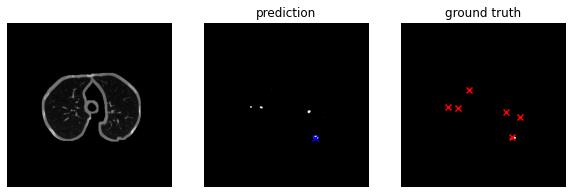

d^2 : 41286.00163769213  |d^2 : 49889.615146290016  |d^2 : 37773.729500986155  |d^2 : 7094.053483282428  |d^2 : 4745.493701184179  |d^2 : 2.731469175522515  |TP: 1, FP: 5, FN: 0


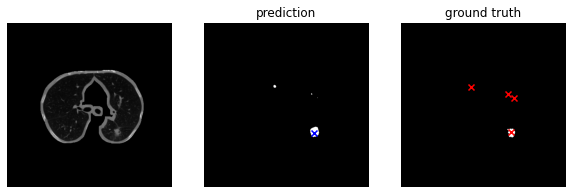

d^2 : 35874.856788874196  |d^2 : 14538.278322617733  |d^2 : 11912.779977529879  |d^2 : 8.801052143059492  |TP: 1, FP: 3, FN: 0


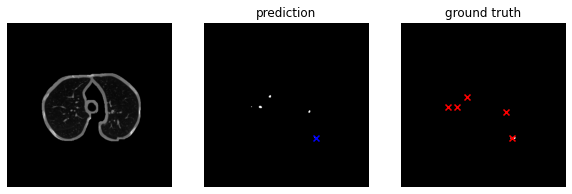

d^2 : 37057.52206015747  |d^2 : 39060.58441351059  |d^2 : 49450.54958338594  |d^2 : 7152.740577282458  |d^2 : 6.954068048274354  |TP: 1, FP: 4, FN: 0


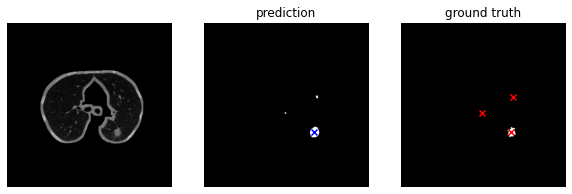

d^2 : 12155.922305929418  |d^2 : 11842.038945763707  |d^2 : 0.0827306240020566  |TP: 1, FP: 2, FN: 0


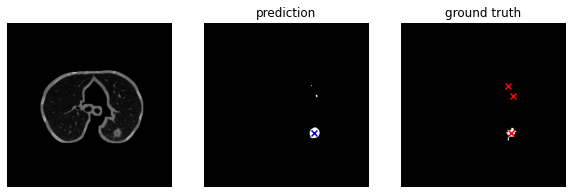

d^2 : 21761.66815270678  |d^2 : 13344.506709426434  |d^2 : 2.4209063523455154  |TP: 1, FP: 2, FN: 0


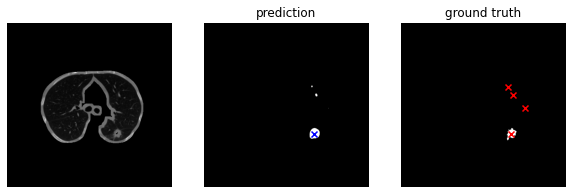

d^2 : 21663.45748506544  |d^2 : 14514.459247172856  |d^2 : 8216.015733151466  |d^2 : 0.6635711746528554  |TP: 1, FP: 3, FN: 0


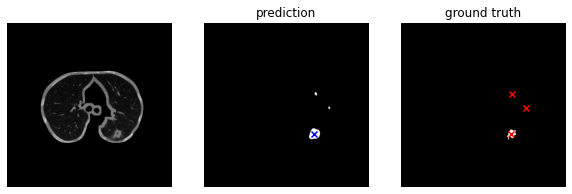

d^2 : 15567.632302944361  |d^2 : 8686.80473647093  |d^2 : 0.09401895814667989  |TP: 1, FP: 2, FN: 0


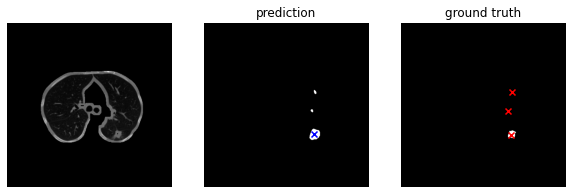

d^2 : 17186.65723842272  |d^2 : 5451.435691390952  |d^2 : 0.6104471078540147  |TP: 1, FP: 2, FN: 0


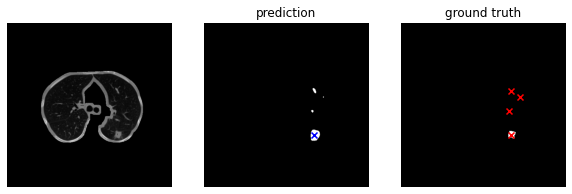

d^2 : 18523.051953882266  |d^2 : 14194.34348535864  |d^2 : 5289.534281609112  |d^2 : 4.777811838579479  |TP: 1, FP: 3, FN: 0


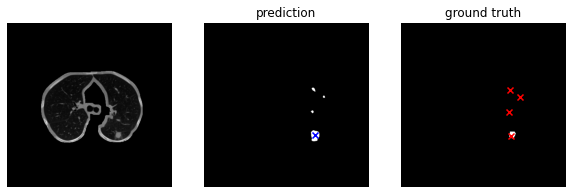

d^2 : 19738.053351370996  |d^2 : 14559.22237552868  |d^2 : 5178.115622667712  |d^2 : 10.27770715702355  |TP: 1, FP: 3, FN: 0


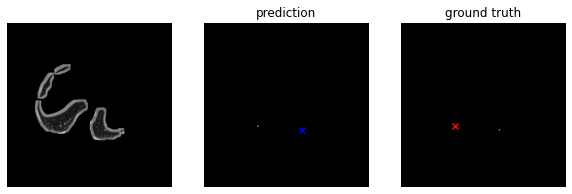

d^2 : 19058.374722222223  |TP: 0, FP: 1, FN: 1


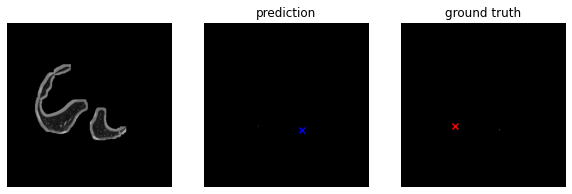

d^2 : 18901.25  |TP: 0, FP: 1, FN: 1


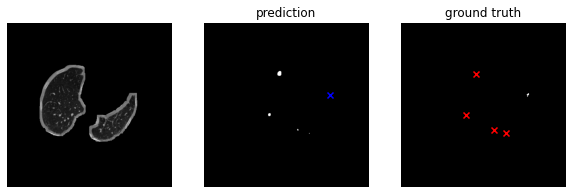

d^2 : 29828.157160923853  |d^2 : 40197.89292327855  |d^2 : 22347.127439953896  |d^2 : 18839.515206722186  |TP: 0, FP: 4, FN: 1


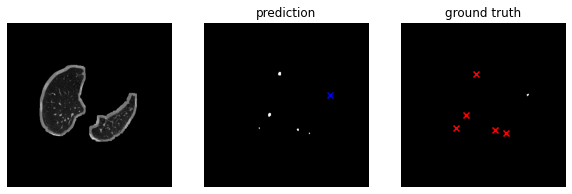

d^2 : 29469.78371563502  |d^2 : 39955.56503137125  |d^2 : 59889.85  |d^2 : 22078.756198767594  |d^2 : 18661.168367346945  |TP: 0, FP: 5, FN: 1


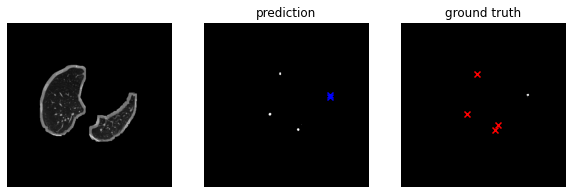

d^2 : 29081.688770087665  |d^2 : 29670.036250000005  |d^2 : 39289.361195539976  |d^2 : 38377.88115702479  |d^2 : 16829.33089846604  |d^2 : 15672.5  |d^2 : 21838.69511815448  |d^2 : 20491.12717013889  |TP: 0, FP: 4, FN: 2


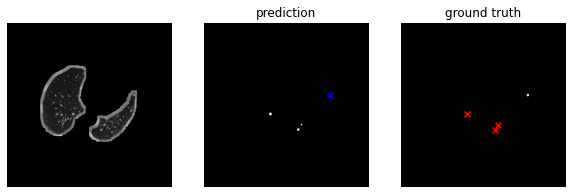

d^2 : 38635.65199336606  |d^2 : 16718.372229689157  |d^2 : 21695.710048586923  |TP: 0, FP: 3, FN: 1


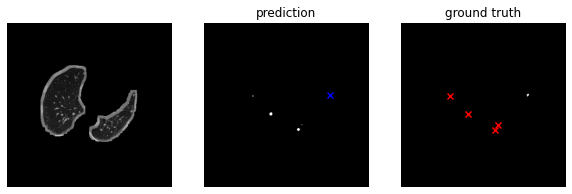

d^2 : 58478.90948212627  |d^2 : 38011.330539719325  |d^2 : 16527.713372781072  |d^2 : 21538.206642011835  |TP: 0, FP: 4, FN: 1


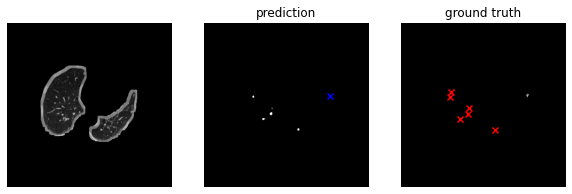

d^2 : 56284.27640036731  |d^2 : 57325.64000519813  |d^2 : 34442.539851202186  |d^2 : 37186.40347983769  |d^2 : 48554.231419306714  |d^2 : 21117.93253232399  |TP: 0, FP: 6, FN: 1


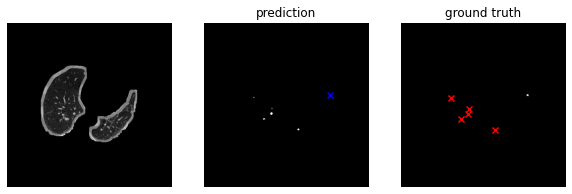

d^2 : 56746.4181632653  |d^2 : 34812.21816326531  |d^2 : 36970.620049796285  |d^2 : 48095.486370510385  |d^2 : 21294.90602194787  |TP: 0, FP: 5, FN: 1


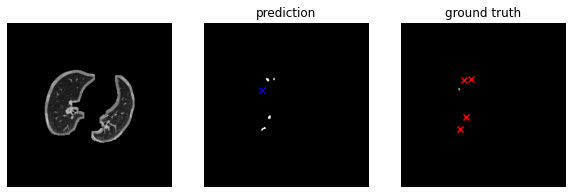

d^2 : 2370.9153924391467  |d^2 : 1178.453305164784  |d^2 : 8078.765337099826  |d^2 : 15061.586593491744  |TP: 0, FP: 4, FN: 1


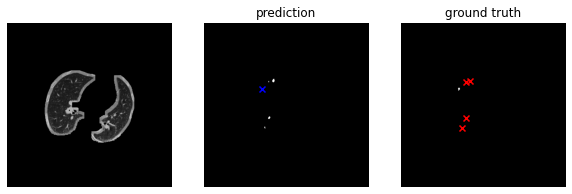

d^2 : 1948.717900037594  |d^2 : 968.408179012346  |d^2 : 8458.757236649863  |d^2 : 14352.595820735698  |TP: 0, FP: 4, FN: 1


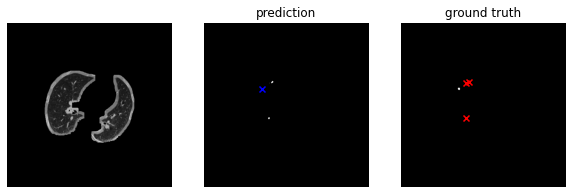

d^2 : 1449.8789159456874  |d^2 : 875.2570677186059  |d^2 : 8792.621034564616  |TP: 0, FP: 3, FN: 1


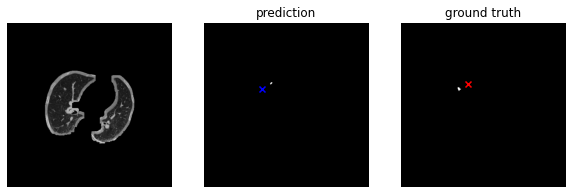

d^2 : 1118.4213957759416  |TP: 0, FP: 1, FN: 1


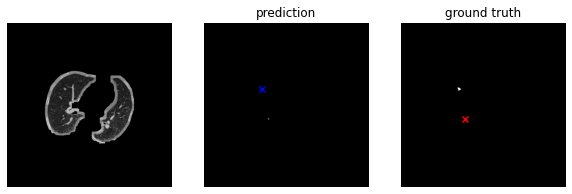

d^2 : 9021.140364854318  |TP: 0, FP: 1, FN: 1


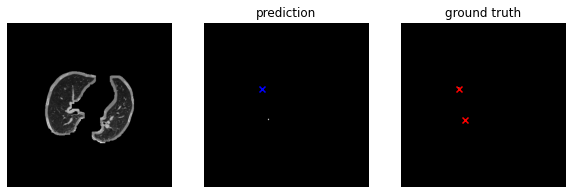

d^2 : 3.298037190082631  |TP: 1, FP: 1, FN: 0


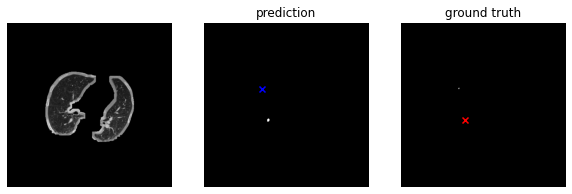

d^2 : 10049.518585017839  |TP: 0, FP: 1, FN: 1


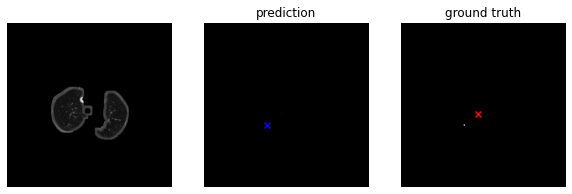

d^2 : 3259.257777777776  |TP: 0, FP: 1, FN: 1


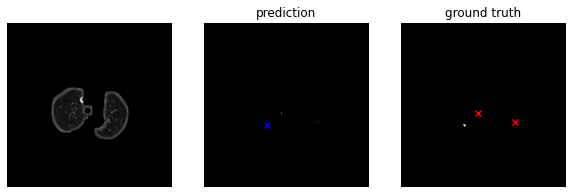

d^2 : 3278.7855229591823  |d^2 : 24871.290625  |TP: 0, FP: 2, FN: 1


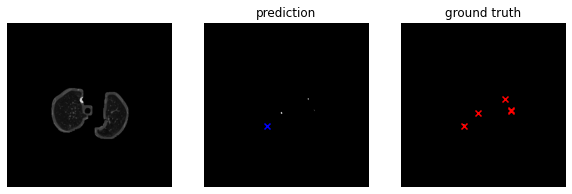

d^2 : 22986.54464467911  |d^2 : 23455.88348765432  |d^2 : 23653.35570987654  |d^2 : 3502.1777320372066  |d^2 : 4.228299408223544  |TP: 1, FP: 4, FN: 0


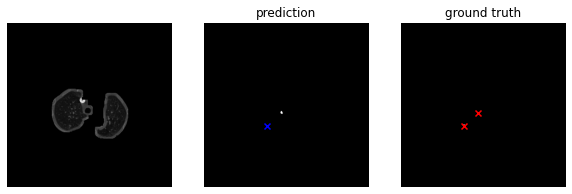

d^2 : 3645.9565089033586  |d^2 : 3.731867283950678  |TP: 1, FP: 1, FN: 0


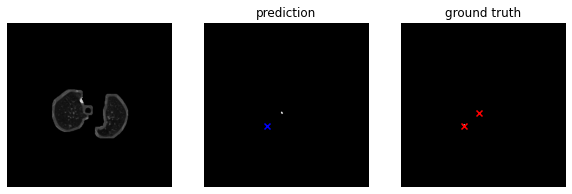

d^2 : 3712.3217998163504  |d^2 : 0.7082644628098956  |TP: 1, FP: 1, FN: 0


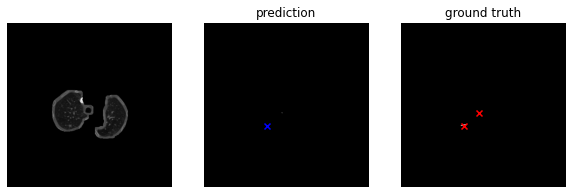

d^2 : 3755.3168981091058  |d^2 : 3.034997470062309  |TP: 1, FP: 1, FN: 0


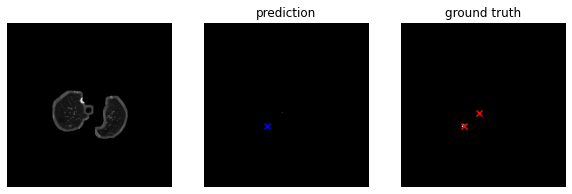

d^2 : 3903.808720374111  |d^2 : 0.9839781060686503  |TP: 1, FP: 1, FN: 0


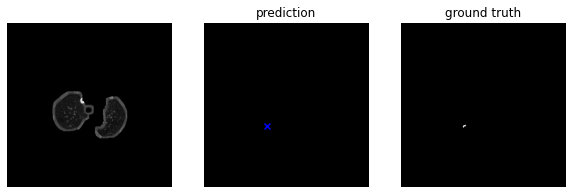

TP: 0, FP: 0, FN: 1


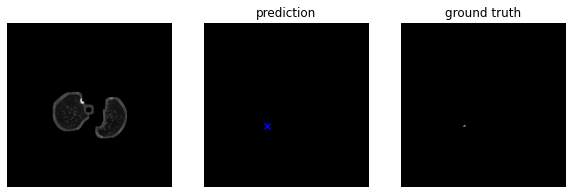

TP: 0, FP: 0, FN: 1


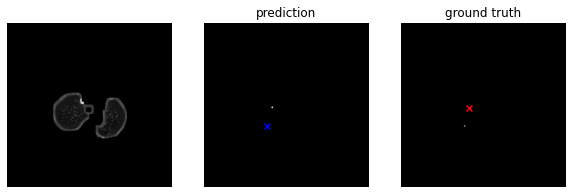

d^2 : 3530.9299999999985  |TP: 0, FP: 1, FN: 1


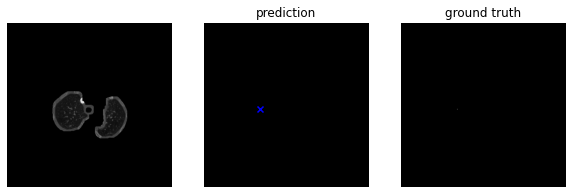

TP: 0, FP: 0, FN: 1


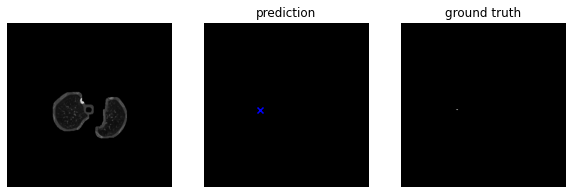

TP: 0, FP: 0, FN: 1


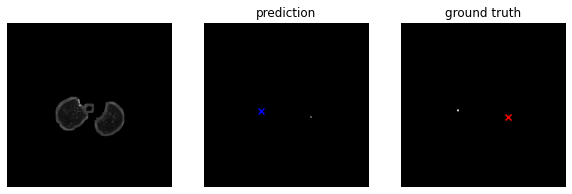

d^2 : 24537.147751479293  |TP: 0, FP: 1, FN: 1


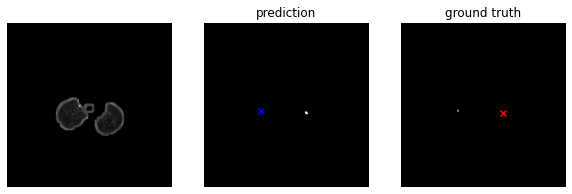

d^2 : 19829.087937767697  |TP: 0, FP: 1, FN: 1


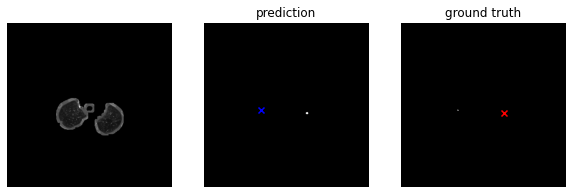

d^2 : 20517.512499999997  |TP: 0, FP: 1, FN: 1


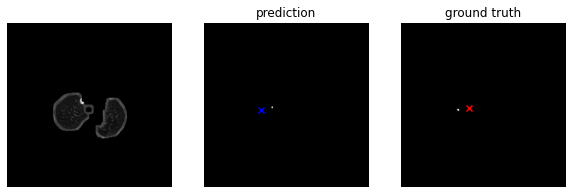

d^2 : 1231.7118877551013  |TP: 0, FP: 1, FN: 1


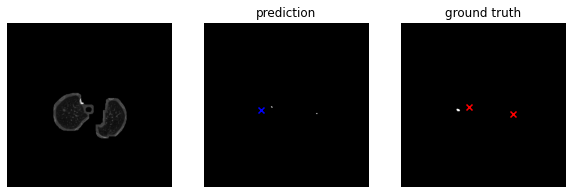

d^2 : 1177.6138876291268  |d^2 : 29939.29309397834  |TP: 0, FP: 2, FN: 1


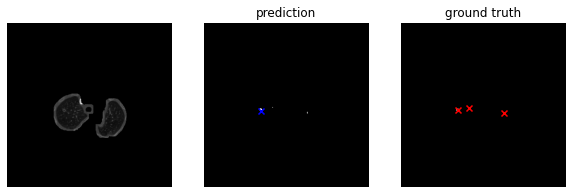

d^2 : 1348.0595847750874  |d^2 : 4.88367690547502  |TP: 1, FP: 2, FN: 0


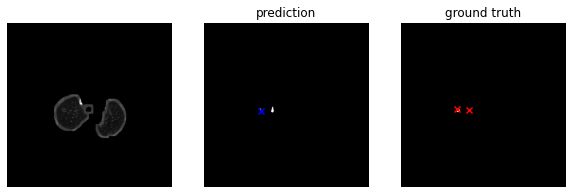

d^2 : 1253.1407349427648  |d^2 : 21.799400401701394  |TP: 1, FP: 1, FN: 0


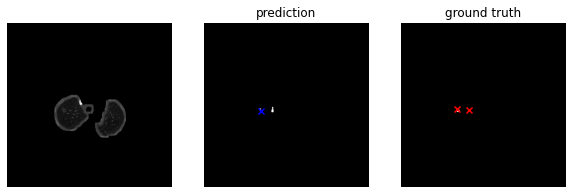

d^2 : 1294.4204834154127  |d^2 : 19.19576084670371  |TP: 1, FP: 1, FN: 0


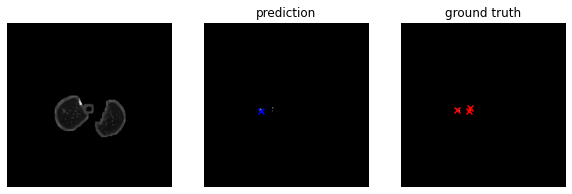

d^2 : 1421.138281249999  |d^2 : 2.5680558559207727  |TP: 1, FP: 2, FN: 0


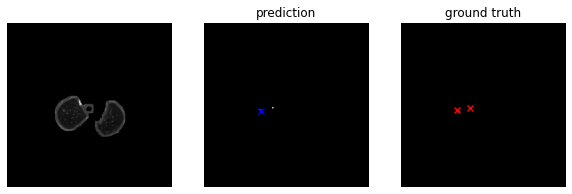

d^2 : 1471.9448224482903  |d^2 : 3.0451843043995312  |TP: 1, FP: 1, FN: 0


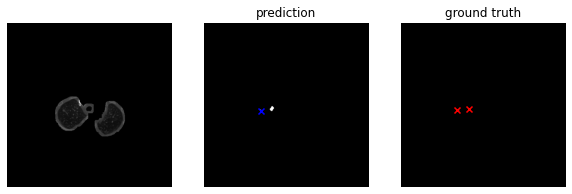

d^2 : 1210.3513368526071  |d^2 : 0.17038548752833688  |TP: 1, FP: 1, FN: 0


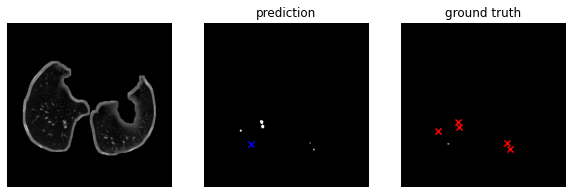

d^2 : 5643.002765774674  |d^2 : 4158.292515544122  |d^2 : 2793.189453125  |d^2 : 33314.515625  |d^2 : 37902.25662222992  |TP: 0, FP: 5, FN: 1


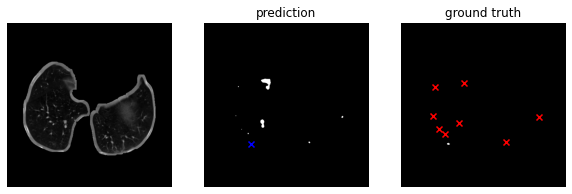

d^2 : 38271.57218739893  |d^2 : 33228.402962292945  |d^2 : 9925.97922437673  |d^2 : 86740.4413856972  |d^2 : 5270.374073290337  |d^2 : 2977.8768851954455  |d^2 : 1143.3587372083978  |d^2 : 32371.0877695492  |TP: 0, FP: 8, FN: 1


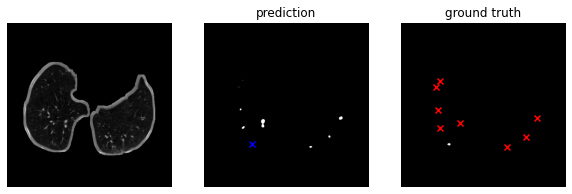

d^2 : 40222.903979238756  |d^2 : 33244.8369857747  |d^2 : 12997.927774173391  |d^2 : 82434.85769149287  |d^2 : 5519.579149950043  |d^2 : 3456.0232262975805  |d^2 : 58186.74625411167  |d^2 : 33201.94634521561  |TP: 0, FP: 8, FN: 1


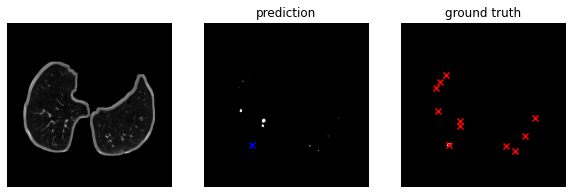

d^2 : 46735.22762474267  |d^2 : 39507.18882902637  |d^2 : 32961.240000980295  |d^2 : 12340.753046545062  |d^2 : 78298.83598557874  |d^2 : 6805.189101368733  |d^2 : 4533.958372244742  |d^2 : 56471.74247622782  |d^2 : 0.54231732304145  |TP: 1, FP: 10, FN: 0


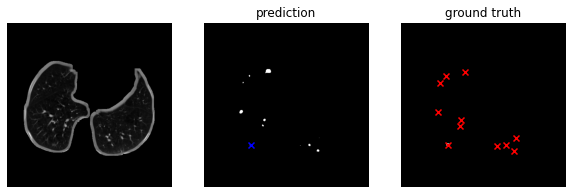

d^2 : 55016.61186445387  |d^2 : 45767.919838096466  |d^2 : 37898.727611312876  |d^2 : 11461.679838723678  |d^2 : 7630.753509003735  |d^2 : 4891.17078671665  |d^2 : 45004.79460207613  |d^2 : 32701.23349913494  |d^2 : 1.924917576810376  |TP: 1, FP: 10, FN: 0


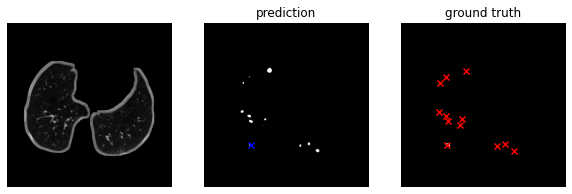

d^2 : 56761.70504199986  |d^2 : 44413.8452457941  |d^2 : 37531.99244509936  |d^2 : 11429.363874625955  |d^2 : 8011.05973353956  |d^2 : 8248.043049142394  |d^2 : 5321.568360638115  |d^2 : 5090.200543232229  |d^2 : 32440.697416883027  |d^2 : 0.7635047358946258  |TP: 1, FP: 11, FN: 0


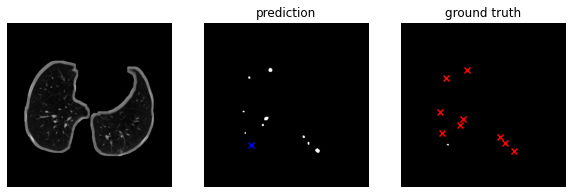

d^2 : 57352.93439058957  |d^2 : 43372.97057524676  |d^2 : 11100.100579840993  |d^2 : 8887.64824606313  |d^2 : 5112.476641556903  |d^2 : 1613.6072845805  |d^2 : 27470.963200751103  |d^2 : 31976.755629111136  |d^2 : 43126.93694587038  |TP: 0, FP: 9, FN: 1


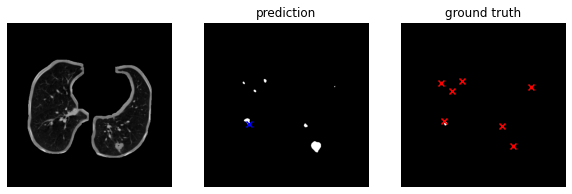

d^2 : 20370.812444861294  |d^2 : 16263.9455037804  |d^2 : 84686.75025567976  |d^2 : 10711.430433256905  |d^2 : 78.9328597131649  |TP: 1, FP: 6, FN: 0


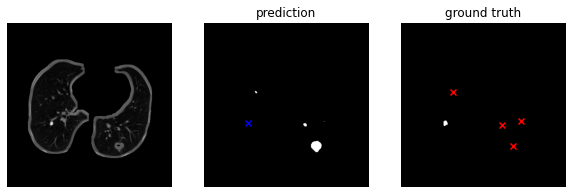

d^2 : 9865.237298816515  |d^2 : 55290.74850381313  |d^2 : 30992.627751835626  |d^2 : 49429.10241121469  |TP: 0, FP: 4, FN: 1


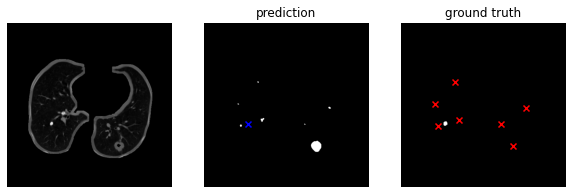

d^2 : 17506.697632881573  |d^2 : 4667.813515234522  |d^2 : 65847.52146374727  |d^2 : 2010.2459684327937  |d^2 : 30671.404855103796  |d^2 : 582.1975021626301  |d^2 : 49348.23975786204  |TP: 0, FP: 7, FN: 1


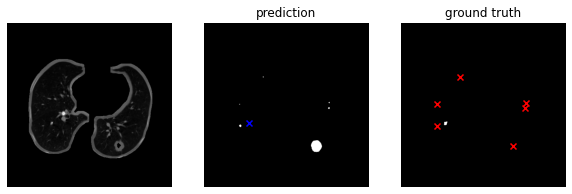

d^2 : 22766.46443666223  |d^2 : 66670.53903738619  |d^2 : 4287.71184639536  |d^2 : 64356.74985715586  |d^2 : 722.8266379530118  |d^2 : 49191.262607901976  |TP: 0, FP: 6, FN: 1


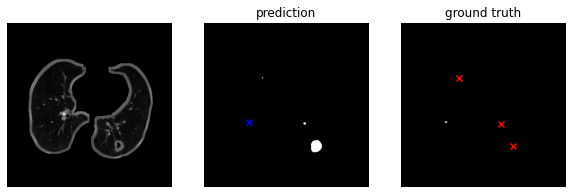

d^2 : 20700.630899908163  |d^2 : 29889.53836805555  |d^2 : 49107.91488824042  |TP: 0, FP: 3, FN: 1


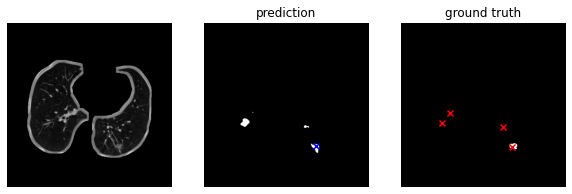

d^2 : 50053.71833831573  |d^2 : 54498.33871507588  |d^2 : 4722.217365599246  |d^2 : 20.007387977826564  |TP: 1, FP: 3, FN: 0


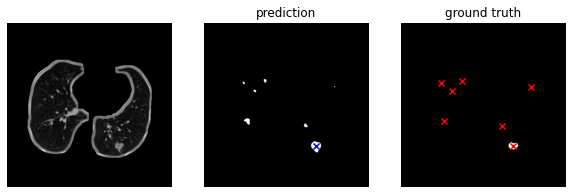

d^2 : 65836.14527754446  |d^2 : 88579.39724881093  |d^2 : 37158.58901073091  |d^2 : 65100.54488196308  |d^2 : 51303.199867785246  |d^2 : 5029.5985754525245  |d^2 : 2.204749160740793  |TP: 1, FP: 6, FN: 0


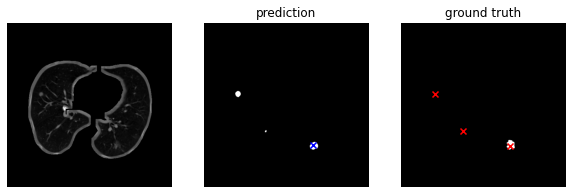

d^2 : 80046.6536542745  |d^2 : 23915.218797556805  |d^2 : 11.79243843104391  |TP: 1, FP: 2, FN: 0


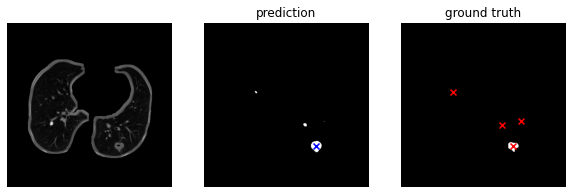

d^2 : 62882.06282004401  |d^2 : 6604.644369493179  |d^2 : 5586.189278406946  |d^2 : 0.5598092793474526  |TP: 1, FP: 3, FN: 0


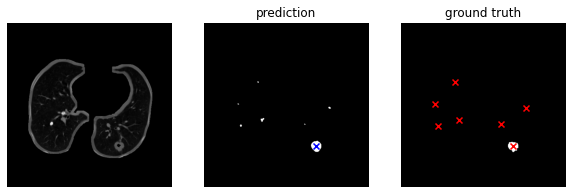

d^2 : 72428.04200159364  |d^2 : 75791.8476947296  |d^2 : 16097.366563842063  |d^2 : 34793.463652605846  |d^2 : 5987.231334627906  |d^2 : 58766.36679896167  |d^2 : 0.5720164324381112  |TP: 1, FP: 6, FN: 0


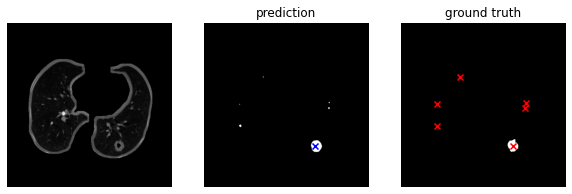

d^2 : 72262.80104156249  |d^2 : 19607.24182592006  |d^2 : 72559.45467031098  |d^2 : 15274.14336243055  |d^2 : 58872.80399899313  |d^2 : 3.3296447968633753  |TP: 1, FP: 5, FN: 0


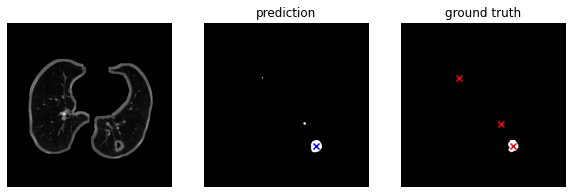

d^2 : 72347.61571137974  |d^2 : 6080.791756856729  |d^2 : 1.0910151652413322  |TP: 1, FP: 2, FN: 0


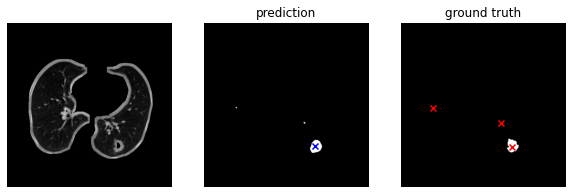

d^2 : 74330.24851497801  |d^2 : 6264.342542960569  |d^2 : 8.12192134311151  |TP: 1, FP: 2, FN: 0


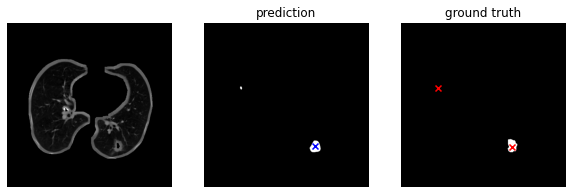

d^2 : 85005.32956858198  |d^2 : 13.2373276146128  |TP: 1, FP: 1, FN: 0


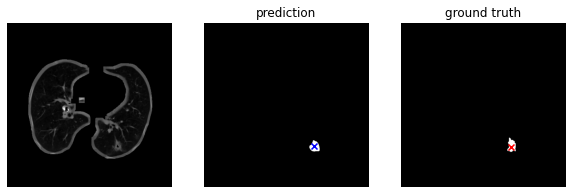

d^2 : 9.304329903398905  |TP: 1, FP: 0, FN: 0


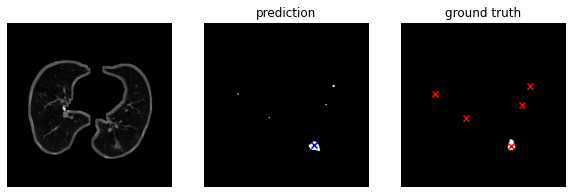

d^2 : 37464.81362701453  |d^2 : 81517.83596548793  |d^2 : 17219.186398533035  |d^2 : 27067.865018015313  |d^2 : 11.560872195724945  |TP: 1, FP: 4, FN: 0


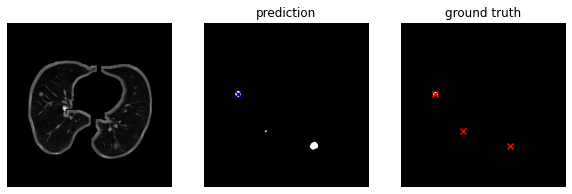

d^2 : 0.30226074868650055  |TP: 1, FP: 2, FN: 0


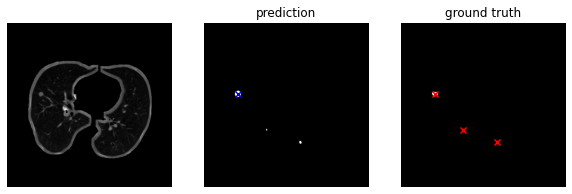

d^2 : 0.14276927504575715  |TP: 1, FP: 2, FN: 0


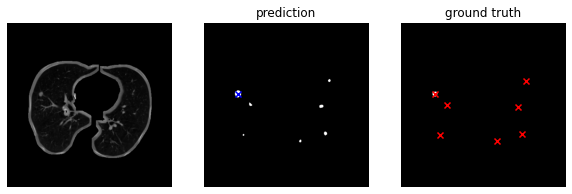

d^2 : 82357.17736781172  |d^2 : 0.36390296316519627  |TP: 1, FP: 6, FN: 0


In [122]:

# model = load_model('model-dsbowl2020-4.h5',{'IoU':IoU})
preds_val = model_bin_cross_entropy.predict(X_test_new, verbose=0)

preds_val_t = (preds_val > 0.1).astype(np.uint8)

TP_t=0
FP_t=0
FN_t=0
pred = []
tr = []

# for ix in range(len(X_test_new)):
ix=5
for ix in range(100):
    TP=0
    FP=0
    FN=0
    pred = []
    tr = []
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')
    for center in get_centers(np.squeeze(preds_val_t[ix][:,:,0])):
        ax[2].scatter(center[1], center[0], marker='x', color='r')
        pred.append(center)
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y[ix][:,:,0]),cmap='gray')
    for center in get_centers(np.squeeze(Y[ix][:,:,0])):
        ax[1].scatter(center[1], center[0], marker='x', color='b')
        tr.append(center)
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    for p in pred:
        for t in tr:
            dist_sq = pow((p[0] - t[0]),2) + pow((p[1] - t[1]),2)
            print("d^2 : {}  |".format(dist_sq),end='')
            if dist_sq < 100:
                TP+=1
                tr.remove(t)
    FP = len(pred) - TP
    for t in tr:
        FN+=1
    print(f"TP: {TP}, FP: {FP}, FN: {FN}")

In [119]:
preds_val = model_bin_cross_entropy.predict(X_test_new, verbose=0)

preds_val_t = (preds_val > 0.1).astype(np.uint8)

TP=0
FP=0
FN=0
# X = X_train_new
# Y = Y_train_new
for ix in range(len(X_test_new)):
    pred = []
    tr = []
    for center in get_centers(np.squeeze(preds_val_t[ix][:,:,0])):
        pred.append(center)
    for center in get_centers(np.squeeze(Y[ix][:,:,0])):
        tr.append(center)
    plt.show()
    for p in pred:
        
        for t in tr:
            dist_sq = pow((p[0] - t[0]),2) + pow((p[1] - t[1]),2)
            # print("d^2 : {}".format(dist_sq))
            if dist_sq < 100:
                TP+=1
                tr.remove(t)
                pred.remove(p)
    FP += len(pred)
    for t in tr:
        FN+=1
print(f"TP: {TP}, FP: {FP}, FN: {FN}")

TP: 189, FP: 752, FN: 147


In [0]:
y_true = [1 for _ in range(TP)] + [0 for _ in range(FP)] + [1 for _ in range(FN)]
y_pred = [1 for _ in range(TP)] + [1 for _ in range(FP)] + [0 for _ in range(FN)]

In [121]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)
precision_recall_fscore_support(y_true, y_pred, average='binary')


(0.20085015940488843, 0.5625, 0.29600626468285046, None)

In [0]:
loss = results.history['loss']
val_loss = results.history['val_loss']
iou = results.history['IoU']
val_iou = results.history['val_IoU']
epoch = len(loss)

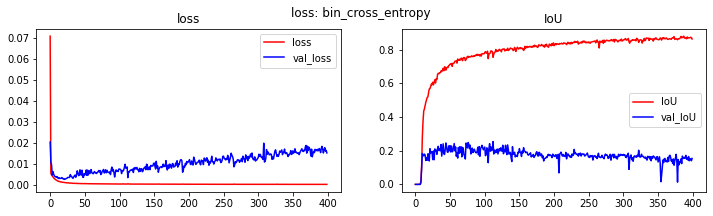

In [48]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(loss,'r', label='loss')
ax1.plot(val_loss,'b', label='val_loss')
ax1.set_title("loss")
ax1.legend(loc="best")
ax2.plot(iou, 'r', label='IoU')
ax2.plot(val_iou, 'b', label='val_IoU')
ax2.set_title("IoU")
ax2.legend(loc="best")
fig.suptitle("loss: bin_cross_entropy")
plt.show()

In [0]:
model_bin_cross_entropy = model

In [0]:
model_bin_cross_entropy.save_weights("saved_w")

TP: 67, FP: 182, FN: 269

(0.26907630522088355, 0.19940476190476192, 0.22905982905982908, None)


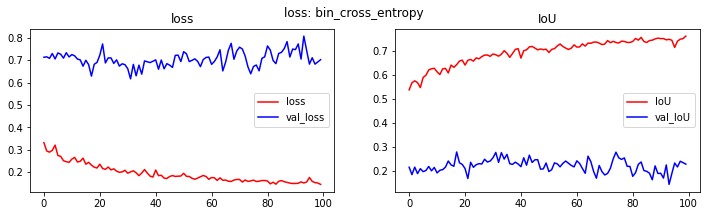

In [67]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(loss,'r', label='loss')
ax1.plot(val_loss,'b', label='val_loss')
ax1.set_title("loss")
ax1.legend(loc="best")
ax2.plot(iou, 'r', label='IoU')
ax2.plot(val_iou, 'b', label='val_IoU')
ax2.set_title("IoU")
ax2.legend(loc="best")
fig.suptitle("loss: bin_cross_entropy")
plt.show()

In [0]:
model_dice_coef = model

TP: 69, FP: 499, FN: 267

(0.12147887323943662, 0.20535714285714285, 0.15265486725663716, None)

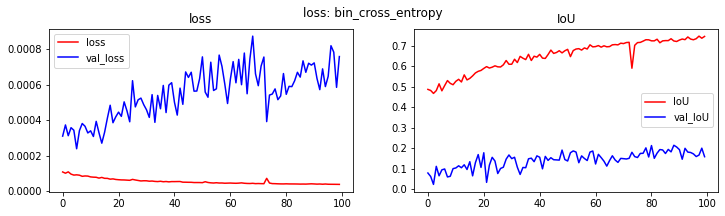

In [83]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(loss,'r', label='loss')
ax1.plot(val_loss,'b', label='val_loss')
ax1.set_title("loss")
ax1.legend(loc="best")
ax2.plot(iou, 'r', label='IoU')
ax2.plot(val_iou, 'b', label='val_IoU')
ax2.set_title("IoU")
ax2.legend(loc="best")
fig.suptitle("loss: bin_cross_entropy")
plt.show()

In [0]:
model_focal_loss = model

TP: 55, FP: 94, FN: 281

(0.3691275167785235, 0.1636904761904762, 0.22680412371134023, None)

In [55]:
!ls

gdrive	model-dsbowl2020-4.h5  sample_data  saved_w


In [0]:
iter_dict = {'shuffle':[True], 'norm':[False,'z',  'mm_norm'],
             'opt':['adam'], 'act':['relu', 'elu']}
opt_dict = {}
opt_dict['adam'] = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
opt_dict['SGD'] = SGD(learning_rate = 0.0001, momentum=0.999)

In [0]:
result2 = {}
for shuffle in iter_dict['shuffle']:
    for norm in iter_dict['norm']:
        for opt in iter_dict['opt']:
            for act in iter_dict['act']:
                for _ in range(3):
                    print("trial {}, {}_{}_{}_{}".format(_+1, shuffle,norm,opt,act))
                    result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)] = iter(shuffle, norm, opt_dict[opt], act, "cross_entropy")
                    print("val_IoU : {}".format(result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)].history['val_IoU'][-1]))


In [0]:
iter(True,'mm_norm' , opt_dict['adam'], 'elu', "cross_entropy")

In [0]:
iter_dict = {'shuffle':[True], 'norm':['mm_norm'],
             'opt':['adam'], 'act':['relu', 'elu']}
for shuffle in iter_dict['shuffle']:
    for norm in iter_dict['norm']:
        for opt in iter_dict['opt']:
            for act in iter_dict['act']:
                for _ in range(3):
                    print("trial {}, {}_{}_{}_{}".format(_+1, shuffle,norm,opt,act))
                    result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)] = iter(shuffle, norm, opt_dict[opt], act, "cross_entropy")
                    print("val_IoU : {}".format(result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)].history['val_IoU'][-1]))


Download history variables

In [0]:
save_result = result

In [0]:
from google.colab import files

In [0]:
files.download(save_result)

In [0]:
import pickle
save_result['False_False_SGD_elu'].history

In [0]:
files.download('history_False_False_SGD_elu1.json')

In [0]:
!rm False_False_adam_relu_2.json

In [0]:
for i in save_result.keys():
    print(i)

In [0]:
for key in save_result.keys():
    for i in range(2):
        with open('{}_{}.json'.format(key,i+1), 'wb') as f:
            pickle.dump(save_result[key].history,f)
        files.download('{}_{}.json'.format(key,i+1))

In [0]:
a = files.upload()

In [0]:
with open('history_False_False_SGD_elu1 (1).json', 'rb') as f:
    data = pickle.load(f)